In [1]:
%matplotlib notebook
import matplotlib.pyplot as plt
import plotting_resources as res
import numpy as np
from astropy.table import Table, vstack, unique
#plt.rc('text', usetex=True)
plt.ion()

dz_mem = 0.02
Rauto_cut = 22.9

In [2]:
def find_histogram_edges(hist, bins):
    xs, ys = [], []
    for i in range(len(hist)):
        xs.append(bins[i])
        xs.append(bins[i+1])
        ys.append(hist[i])
        ys.append(hist[i])
    return xs, ys

In [3]:
def calc_uncert(row):
    return np.sqrt(np.sum(row**2)/float(len(row)))

## Load the data, make cuts and calculate dzs

In [4]:
# Load the table and make cuts
primus_table = Table().read('../catalogs/personal_catalogs/slits_phot_zs_cutonslitdist_rcl.csv', format='csv')
subtable = primus_table[np.where(primus_table['zSpec'] > 0.0)]
#subtable = subtable[np.where((subtable['Rauto'] > 0.) & (subtable['Rauto'] < Rauto_cut))]
subtable = subtable[np.where(subtable['zLDP_good'] == 1)]
subtable = subtable[np.where(subtable['zSpec_Q'] == 1)]
subtable = subtable[np.where(subtable['zLDP'] < 0.85)]
subtable = subtable[np.where(subtable['slit_distance'] < 0.5)]

In [5]:
# Calculate delta-z for each object in subtable
subtable['dz_ldp'] = subtable['zLDP'] - subtable['zSpec']

In [6]:
# Make tables for each Q value
Q4 = subtable[np.where(subtable['Q'] == 4)]
Q3 = subtable[np.where(subtable['Q'] >= 3)]
Q2 = subtable[np.where(subtable['Q'] >= 2)]

## Set up the plot

<IPython.core.display.Javascript object>


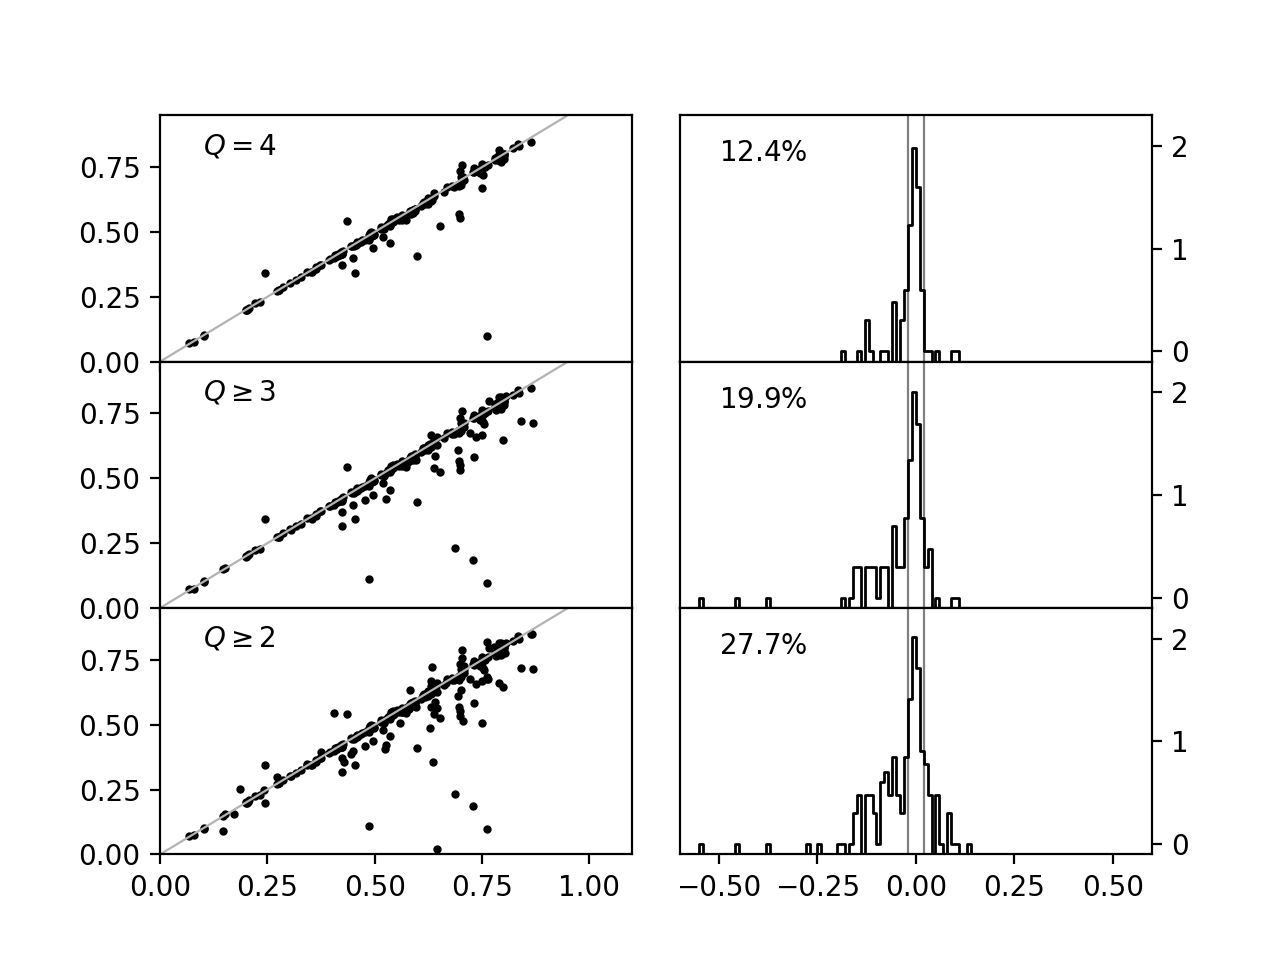

In [7]:
# Set up the giant plot
f, ((a0, a1), (a2, a3), (a4, a5)) = plt.subplots(3,2)
plt.setp([a.get_xticklabels() for a in f.axes[0:-2]], visible=False)
f.subplots_adjust(hspace=0, wspace=0.1)

## Make the zvz plots

In [8]:
for i in range(3):
    eval('a'+str(2*i)).plot(eval('Q'+str(4-i))['zSpec'], eval('Q'+str(4-i))['zLDP'], '.k', ms=4)
    eval('a' + str(2 * i)).plot(np.arange(0.,1.1, 0.1), np.arange(0.,1.1, 0.1), '0.7', lw=0.8)
    
    eval('a' + str(2 * i)).set_xlim([0, 1.1])
    eval('a' + str(2 * i)).set_ylim([0, 0.95])

    if i == 0:
        eval('a' + str(2 * i)).text(0.1, 0.8, r'$Q=%i$' % (4-i))
    elif i > 0:
        eval('a' + str(2 * i)).text(0.1, 0.8, r'$Q\geq%i$' % (4-i))

## Make the residual plots

In [9]:
bins = np.arange(-0.6, 0.61, 0.01)
for i in range(3):
    hist, b = np.histogram(eval('Q'+str(4-i))['dz_ldp'], bins=bins)
    loghist = np.log10(hist)
    loghist[np.isinf(loghist)] = -1

    # Find the percentage of outliers
    N_tot = len(eval('Q'+str(4-i))['dz_ldp'])
    N_good = len(eval('Q'+str(4-i))[np.where(abs(eval('Q'+str(4-i))['dz_ldp']) <= dz_mem)])
    percent_good = 100.*(1.0 - float(N_good)/float(N_tot))

    xs, ys = find_histogram_edges(loghist, bins)
    eval('a' + str(2 * i + 1)).plot(xs, ys, '-k', lw=1)
    eval('a' + str(2 * i + 1)).vlines([dz_mem,-dz_mem], -0.1, 2.3, colors='0.5', lw=0.8)

    eval('a' + str(2 * i + 1)).set_xlim([-0.6, 0.6])
    eval('a' + str(2 * i + 1)).set_ylim([-0.1, 2.3])
    eval('a' + str(2 * i + 1)).yaxis.tick_right()
    eval('a' + str(2 * i + 1)).text(-0.5, 1.85, r'${:.1f} \%$'.format(percent_good))

/Users/matthewkirby/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:4: RuntimeWarning: divide by zero encountered in log10
  after removing the cwd from sys.path.


# Calculate the dispersions

In [14]:
sig4=calc_uncert(Q4['dz_ldp'])
sig3=calc_uncert(Q3['dz_ldp'])
sig2=calc_uncert(Q2['dz_ldp'])

In [15]:
print(sig4, sig3, sig2)

0.05816942678061596 0.08011466437046502 0.08986947684143655


# 5-Sigma clipping

In [20]:
def sigma_clip(table, nsigma, entry):
    i = 1

    while True:
        n_fit = len(table)
        print("Iteration {}, {} objects".format(i, n_fit))
        # Calculate sigma
        sig = calc_uncert(table[entry])
        
        # Clip
        table = table[np.where(abs(table[entry]) < nsigma*sig)]

        # Check
        if n_fit == len(table):
            return sig
        i+=1

Q4['dz/z'] = Q4['dz_ldp']/(1+Q4['zSpec'])
print(sigma_clip(Q4, 3, 'dz_ldp'))
print(sigma_clip(Q4, 3, 'dz/z'))

Iteration 1, 178 objects
Iteration 2, 176 objects
Iteration 3, 169 objects
Iteration 4, 164 objects
Iteration 5, 161 objects
Iteration 6, 158 objects
0.007232511062920167
Iteration 1, 178 objects
Iteration 2, 176 objects
Iteration 3, 169 objects
Iteration 4, 164 objects
Iteration 5, 160 objects
Iteration 6, 159 objects
Iteration 7, 158 objects
0.004498474106006648


In [21]:
DZQ4 = subtable[np.where(subtable['Q5_7'] == 4)]
DZQ4['dz_dj'] = (DZQ4['zLDP5_7'] - DZQ4['zSpec'])/(1.+DZQ4['zSpec'])
print(sigma_clip(DZQ4, 3, 'dz_dj'))

Iteration 1, 167 objects
Iteration 2, 162 objects
Iteration 3, 157 objects
Iteration 4, 151 objects
Iteration 5, 145 objects
Iteration 6, 142 objects
Iteration 7, 140 objects
0.004323638095663639


# What if we only include objects close to the clusters?

In [74]:
cldict = res.load_clusters()

In [75]:
nearcl = Table()
for cl in cldict:
    temptable = subtable[np.where(abs(subtable['zSpec']-cl['z']) < dz_mem)]
    nearcl = vstack([nearcl, temptable])
nearcl = unique(nearcl)

In [76]:
Q4near = nearcl[np.where(nearcl['Q'] == 4)]
len(Q4near)

145